In [1]:
from src.simulation.simulation import *
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

from src.utils.dataset_utils import *
from src.utils.plot_builder.plot_builder import *
from src.utils.plot_builder.plot_types import *
from src.models.fcnn import FCNN

import os

In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
number_of_frames = 250
discretization_size = 290
d = (0.1, 0.3, 0.3)
N = (number_of_frames, discretization_size, discretization_size)
myu_size = (50, 10, 10)
myu_mstd = (5.4, 0.6)

sim = Simulation(
    d=d,
    N=N,
    myu_size=myu_size,
    myu_mstd=myu_mstd
)

state, myu = sim.compute()

Computing States: 100%|██████████| 249/249 [00:02<00:00, 85.97it/s]


In [4]:
dataset = GLDataset(state=state, myu=myu)
dataloader = GLDataLoader(dataset=dataset)

In [5]:
dataset = StateDataset(state, myu)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, pin_memory=True, num_workers=os.cpu_count() // 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Model
model = FCNN(input_dim=3, output_dim=2, hidden_layers=[512, 256, 256]).to(device)

Using device: cuda:0


In [17]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scaler = GradScaler(enabled=torch.cuda.is_available())

epochs = 5
gradient_accumulation_steps = 4
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")

    for step, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(enabled=torch.cuda.is_available()):
            predictions = model(inputs)
            loss = criterion(predictions, targets) / gradient_accumulation_steps  # Normalize loss for accumulation

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()

        epoch_loss += loss.item() * gradient_accumulation_steps
        progress_bar.set_postfix(loss=loss.item() * gradient_accumulation_steps)

    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss / len(dataloader):.6f}")

torch.save(model.state_dict(), "../src/models/fcnn_predictor.pth")
print("Training complete.")
print("Model saved to 'fcnn_predictor.pth'")

C:\Users\meloy\AppData\Local\Temp\ipykernel_14276\1226669714.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
Epoch 1/5:   0%|          | 0/20533 [00:00<?, ?it/s]C:\Users\meloy\AppData\Local\Temp\ipykernel_14276\1226669714.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch 1/5: 100%|██████████| 20533/20533 [01:22<00:00, 250.23it/s, loss=0.243]


Epoch 1, Average Loss: 0.484495


Epoch 2/5: 100%|██████████| 20533/20533 [01:19<00:00, 257.24it/s, loss=0.155]


Epoch 2, Average Loss: 0.216158


Epoch 3/5: 100%|██████████| 20533/20533 [01:17<00:00, 264.32it/s, loss=0.197]


Epoch 3, Average Loss: 0.173140


Epoch 4/5: 100%|██████████| 20533/20533 [01:15<00:00, 270.88it/s, loss=0.136]


Epoch 4, Average Loss: 0.150989


Epoch 5/5: 100%|██████████| 20533/20533 [01:15<00:00, 272.03it/s, loss=0.138] 

Epoch 5, Average Loss: 0.135342
Training complete.
Model saved to 'fcnn_predictor.pth'


In [18]:
model.load_state_dict(torch.load("../src/models/fcnn_predictor.pth"))
model.eval().to(device)

C:\Users\meloy\AppData\Local\Temp\ipykernel_14276\956753462.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../src/models/fcnn_predicto

FCNN(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [19]:
def predict_linespace(t_values, x_values, y_values, model, device):
    grid = torch.tensor([
        [t, x, y] for t in t_values for x in x_values for y in y_values
    ], dtype=torch.float32, device=device)

    with torch.no_grad():
        predictions = model(grid)

    real_parts = predictions[:, 0].reshape(len(t_values), len(x_values), len(y_values))
    imag_parts = predictions[:, 1].reshape(len(t_values), len(x_values), len(y_values))

    return real_parts, imag_parts

In [20]:
torch.linspace(start=0, end=250, steps=2)

tensor([  0., 250.])

In [21]:
# Generate grid values
t_values = torch.linspace(0, 1, 200, device=device)
x_values = torch.linspace(0, 1, 200, device=device)
y_values = torch.linspace(0, 1, 200, device=device)

real_parts, imag_parts = predict_linespace(t_values, x_values, y_values, model, device)

print("Real parts shape:", real_parts.shape)
print("Imaginary parts shape:", imag_parts.shape)

Real parts shape: torch.Size([200, 200, 200])
Imaginary parts shape: torch.Size([200, 200, 200])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

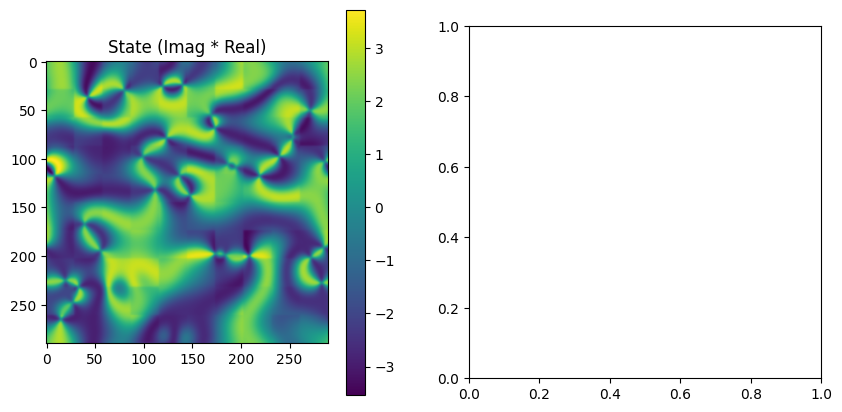

In [22]:
u_pred = real_parts + 1j * imag_parts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(state[199].imag * state[199].real)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title("State (Imag * Real)")

img2 = ax[1].imshow(u_pred[199].imag * u_pred[199].real)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Predict")

plt.tight_layout()
plt.show()

In [10]:
def prepare_cnn_inputs(inputs):
    """
    Reshape inputs to match the CNN's expected input shape.
    CNN expects inputs in [batch_size, channels, height, width].
    Add zero-padding if the number of features is not a perfect square.
    """
    batch_size, num_features = inputs.shape
    next_square = int(np.ceil(np.sqrt(num_features)) ** 2)  # Next perfect square
    padding_size = next_square - num_features

    # Add padding
    if padding_size > 0:
        inputs = torch.cat([inputs, torch.zeros(batch_size, padding_size, device=inputs.device)], dim=1)

    height = width = int(np.sqrt(next_square))
    return inputs.view(batch_size, 1, height, width)

In [8]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # AdamW optimizer
scaler = GradScaler(enabled=torch.cuda.is_available())  # Enable mixed-precision training

# Training parameters
epochs = 5
gradient_accumulation_steps = 4  # Simulates larger batch sizes

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")

    for step, (inputs, targets) in enumerate(progress_bar):
        # Prepare CNN-compatible inputs (reshaped into image-like format)
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        inputs = inputs.view(-1, *input_dim)  # Reshape to match CNN input: (batch_size, channels, height, width)

        optimizer.zero_grad()

        # Mixed Precision Training
        with autocast(enabled=torch.cuda.is_available()):
            predictions = model(inputs)  # Forward pass
            loss = criterion(predictions, targets) / gradient_accumulation_steps  # Normalize loss for accumulation

        # Backward pass and gradient scaling
        scaler.scale(loss).backward()

        # Update weights after accumulating gradients
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()

        # Accumulate epoch loss for reporting
        epoch_loss += loss.item() * gradient_accumulation_steps
        progress_bar.set_postfix(loss=loss.item() * gradient_accumulation_steps)

    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss / len(dataloader):.6f}")

# Save Model
torch.save(model.state_dict(), "../src/models/cnn_predictor.pth")
print("Training complete. Model saved to 'cnn_predictor.pth'")

C:\Users\meloy\AppData\Local\Temp\ipykernel_34484\774486362.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())  # Enable mixed-precision training
Epoch 1/5:   0%|          | 0/20533 [00:02<?, ?it/s]


RuntimeError: shape '[-1, 1, 28, 28]' is invalid for input of size 3072

In [7]:
from src.models.cnn import CNN  # Import your CNN model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = (1, 28, 28)  # Example input dimensions (single channel, 28x28 images)
num_classes = 10  # Example: 10 classes for classification
hidden_channels = 32  # Example: number of hidden channels
batch_size = 16  # Example batch size

# Create model
model = CNN(input_dim=input_dim, num_classes=num_classes, hidden_channels=hidden_channels).to(device)

# Generate random input
inputs = torch.rand(batch_size, *input_dim).to(device)  # Adjusted for 2D image input
outputs = model(inputs)
print(outputs.shape)

torch.Size([16, 10])
